In [1]:
import tensorflow as tf
print("Num GPUs Available:",len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version:",tf.__version__)
if tf.test.gpu_device_name():
    print('Default GPU Device:',tf.test.gpu_device_name())
else:
    print("Gpu device not found.")

Num GPUs Available: 0
Tensorflow version: 2.19.0
Gpu device not found.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model



In [2]:
import tensorflow as tf

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
print('X_train Shape: {}'.format(X_train.shape))
print('X_test Shape: {}'.format(X_test.shape))
print('Y_train Shape: {}'.format(y_train.shape))
print('Y_test Shape: {}'.format(y_test.shape))

X_train Shape: (50000, 32, 32, 3)
X_test Shape: (10000, 32, 32, 3)
Y_train Shape: (50000, 1)
Y_test Shape: (10000, 1)


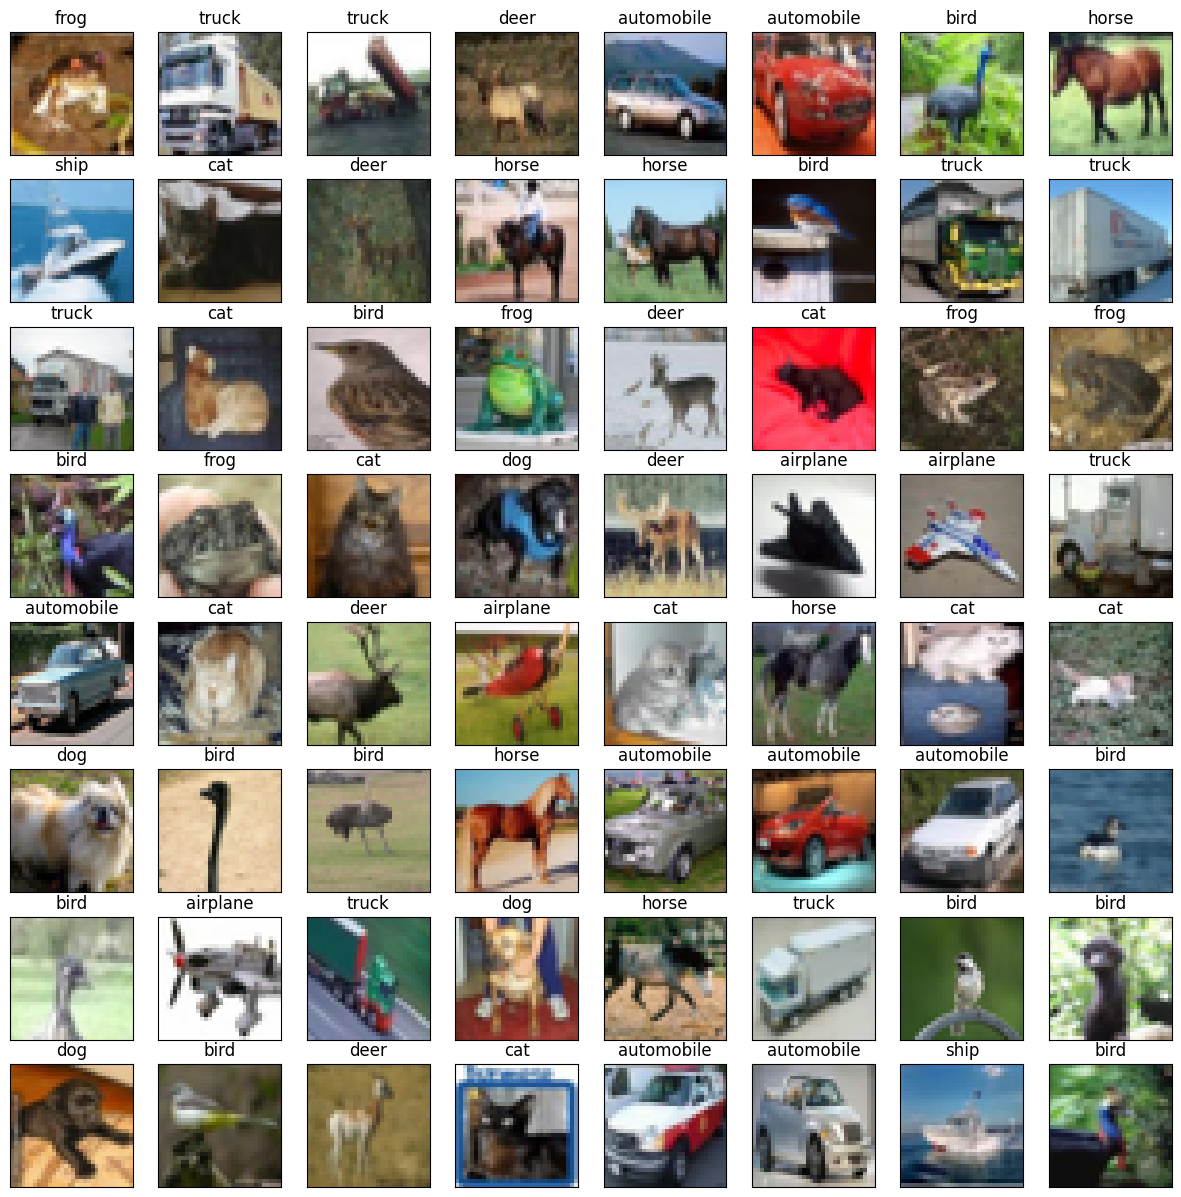

In [5]:
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
               
# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(X_train[i])

    # Set the label as the title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

In [6]:
#normalize the image data and covert pixel values data types to float32
X_train=X_train.astype('float32')/255.0
X_test=X_test.astype('float32')/255.0

In [7]:
#one hot encoding of labels
y_train=to_categorical(y_train,10)
y_test=to_categorical(y_test,10)


In [8]:
# Data augmentation
data_generator = ImageDataGenerator(
    # Rotate images randomly by up to 15 degrees
    rotation_range=15,
    
    # Shift images horizontally by up to 12% of their width
    width_shift_range=0.12,
    
    # Shift images vertically by up to 12% of their height
    height_shift_range=0.12,
    
    # Randomly flip images horizontally
    horizontal_flip=True,
    
    # Zoom images in by up to 10%
    zoom_range=0.1,
    
    # Change brightness by up to 10%
    brightness_range=[0.9,1.1],

    # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=10,
    
    # Channel shift intensity
    channel_shift_range=0.1,
)
data_generator.fit(X_train)

In [9]:
#define  CNN Model Architecture
model=Sequential()


# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=l2(weight_decay),input_shape=(32,32,3)))

#Add BatchNormalization layer

model.add(BatchNormalization())

#Add second Convolution layer

model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

#Add the first pooling layer with pooling size 2x2
model.add(MaxPooling2D(pool_size=(2,2)))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))
# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.5))

# Flatten the tensor output from the previous layer
model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(10, activation='softmax'))


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 64)       │       147,520 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 650,026 (2.48 MB)

 Trainable params: 647,594 (2.47 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [ ]:
#Train the Cnn Model

# Compile the model with the defined optimizer, loss function, and metrics

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Add EarlyStopping callback
# Here, training will be stopped if no improvement in validation loss is observed for 30 epochs.
# The `restore_best_weights` parameter ensures that the model weights are reset to the values from the epoch
# with the best value of the monitored quantity (in this case, 'val_loss').

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# Fit the model on the training data, using the defined batch size and number of epochs
# The validation data is used to evaluate the model's performance during training
# The callbacks implemented are learning rate reduction when a plateau is reached in validation loss and
# stopping training early if no improvement is observed

history = model.fit(
    data_generator.flow(X_train, y_train, batch_size=64),
    epochs=150,
    validation_data=(X_test,y_test),
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.1013 - loss: 3.0943
Epoch 1: val_accuracy improved from -inf to 0.10880, saving model to best_cnn_model.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 428s 523ms/step - accuracy: 0.1013 - loss: 3.0940 - val_accuracy: 0.1088 - val_loss: 2.6098
Epoch 2/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.0993 - loss: 2.5903
Epoch 2: val_accuracy did not improve from 0.10880
782/782 ━━━━━━━━━━━━━━━━━━━━ 415s 530ms/step - accuracy: 0.0993 - loss: 2.5903 - val_accuracy: 0.0995 - val_loss: 3.5240
Epoch 3/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.1006 - loss: 2.4822
Epoch 3: val_accuracy improved from 0.10880 to 0.11520, saving model to best_cnn_model.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 331s 423ms/step - accuracy: 0.1006 - loss: 2.4821 - val_accuracy: 0.1152 - val_loss: 2.5066
Epoch 4/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.1013 - loss: 2.4410
Epoch 4: val_accuracy improved from 0.11520 to 0.11570, saving model to best_cnn_model.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 326s 416ms/step - accuracy: 0.1013 - loss: 2.4410 - val_accuracy: 0.1157 - val_loss: 2.8781
Epoch 5/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.1019 - loss: 2.4083
Epoch 5: val_accuracy did not improve from 0.11570
782/782 ━━━━━━━━━━━━━━━━━━━━ 307s 393ms/step - accuracy: 0.1019 - loss: 2.4083 - val_accuracy: 0.1102 - val_loss: 3.5359
Epoch 6/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.0966 - loss: 2.3941
Epoch 6: val_accuracy did not improve from 0.11570
782/782 ━━━━━━━━━━━━━━━━━━━━ 333s 426ms/step - accuracy: 0.0966 - loss: 2.3941 - val_accuracy: 0.1005 - val_loss: 3.1533
Epoch 7/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.1023 - loss: 2.3816
Epoch 7: val_accuracy did not improve from 0.11570
782/782 ━━━━━━━━━━━━━━━━━━━━ 331s 423ms/step - accuracy: 0.1023 - loss: 2.3816 - val_accuracy: 0.1013 - val_loss: 2.6686
Epoch 8/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.1017 - loss: 2.3767
Epoch 8

782/782 ━━━━━━━━━━━━━━━━━━━━ 317s 406ms/step - accuracy: 0.1056 - loss: 2.3685 - val_accuracy: 0.1197 - val_loss: 2.4068
Epoch 10/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.1023 - loss: 2.3606
Epoch 10: val_accuracy did not improve from 0.11970
782/782 ━━━━━━━━━━━━━━━━━━━━ 306s 392ms/step - accuracy: 0.1023 - loss: 2.3606 - val_accuracy: 0.1010 - val_loss: 2.5461
Epoch 11/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.0999 - loss: 2.3622
Epoch 11: val_accuracy improved from 0.11970 to 0.11990, saving model to best_cnn_model.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 323s 413ms/step - accuracy: 0.0999 - loss: 2.3622 - val_accuracy: 0.1199 - val_loss: 2.3667
Epoch 12/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.1018 - loss: 2.3557
Epoch 12: val_accuracy did not improve from 0.11990
782/782 ━━━━━━━━━━━━━━━━━━━━ 316s 404ms/step - accuracy: 0.1017 - loss: 2.3557 - val_accuracy: 0.1002 - val_loss: 2.5781
Epoch 13/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.1012 - loss: 2.3468
Epoch 13: val_accuracy did not improve from 0.11990
782/782 ━━━━━━━━━━━━━━━━━━━━ 316s 403ms/step - accuracy: 0.1012 - loss: 2.3468 - val_accuracy: 0.1035 - val_loss: 2.3816
Epoch 14/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.1029 - loss: 2.3438
Epoch 14: val_accuracy did not improve from 0.11990
782/782 ━━━━━━━━━━━━━━━━━━━━ 310s 396ms/step - accuracy: 0.1029 - loss: 2.3438 - val_accuracy: 0.1050 - val_loss: 2.3029
Epoch 15/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.1012 - loss: 2.3371


782/782 ━━━━━━━━━━━━━━━━━━━━ 371s 474ms/step - accuracy: 0.1013 - loss: 2.3251 - val_accuracy: 0.1230 - val_loss: 2.6079
Epoch 24/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.0999 - loss: 2.3284
Epoch 24: val_accuracy did not improve from 0.12300
782/782 ━━━━━━━━━━━━━━━━━━━━ 375s 479ms/step - accuracy: 0.0999 - loss: 2.3284 - val_accuracy: 0.1190 - val_loss: 2.3680
Epoch 25/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.0995 - loss: 2.3262
Epoch 25: val_accuracy did not improve from 0.12300
782/782 ━━━━━━━━━━━━━━━━━━━━ 372s 475ms/step - accuracy: 0.0995 - loss: 2.3262 - val_accuracy: 0.0941 - val_loss: 2.3784
Epoch 26/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.1045 - loss: 2.3237
Epoch 26: val_accuracy did not improve from 0.12300
782/782 ━━━━━━━━━━━━━━━━━━━━ 377s 482ms/step - accuracy: 0.1045 - loss: 2.3237 - val_accuracy: 0.1041 - val_loss: 3.2392
Epoch 27/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.1033 - loss: 2.3262


782/782 ━━━━━━━━━━━━━━━━━━━━ 311s 377ms/step - accuracy: 0.1063 - loss: 2.3085 - val_accuracy: 0.1561 - val_loss: 2.2602
Epoch 47/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.1037 - loss: 2.3063
Epoch 47: val_accuracy did not improve from 0.15610
782/782 ━━━━━━━━━━━━━━━━━━━━ 328s 385ms/step - accuracy: 0.1037 - loss: 2.3063 - val_accuracy: 0.1065 - val_loss: 2.2982
Epoch 48/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.1063 - loss: 2.3077
Epoch 48: val_accuracy did not improve from 0.15610
782/782 ━━━━━━━━━━━━━━━━━━━━ 294s 376ms/step - accuracy: 0.1063 - loss: 2.3077 - val_accuracy: 0.1061 - val_loss: 2.3237
Epoch 49/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.1050 - loss: 2.3100
Epoch 49: val_accuracy did not improve from 0.15610
782/782 ━━━━━━━━━━━━━━━━━━━━ 295s 377ms/step - accuracy: 0.1050 - loss: 2.3100 - val_accuracy: 0.1235 - val_loss: 2.4022
Epoch 50/150
513/782 ━━━━━━━━━━━━━━━━━━━━ 13:37 3s/step - accuracy: 0.1062 - loss: 2.3081

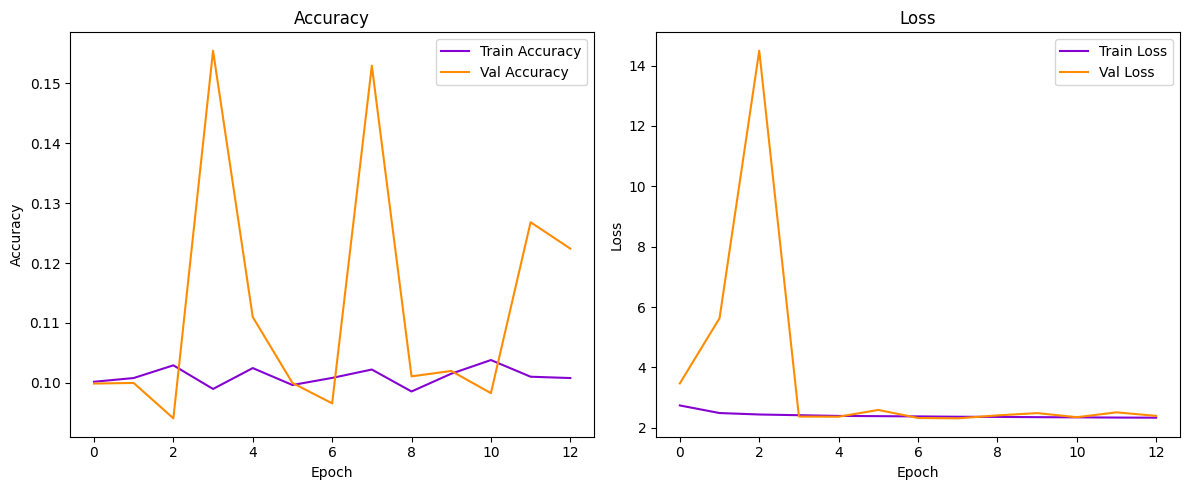

In [24]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Val Accuracy',color='darkorange')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss',color='#8502d1')
plt.plot(history.history['val_loss'], label='Val Loss',color='darkorange')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
model.load_weights('best_cnn_model.h5')
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)
print(f"Test Accuracy: {test_acc*100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.1556 - loss: 2.3812

Test Accuracy: 0.15539999306201935
Test Loss:     2.3732669353485107
Test Accuracy: 15.54%
